In [1]:
import m2aia as m2
from m2aia.utils import volcano
from m2aia.utils import binning
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import seaborn_image as seai
import SimpleITK as sitk
import wget
import zipfile
import pathlib

if not pathlib.Path("47TopRight, 57BottomRight, 67BottomLeft, 77TopLeft-centroid.imzML").exists():
    name = wget.download("https://data.jtfc.de/MTBLS282_47TopRight_Centroids.zip")
    with zipfile.ZipFile(name, 'r') as zip_ref:
        zip_ref.extractall()

image = m2.ImzMLReader("47TopRight, 57BottomRight, 67BottomLeft, 77TopLeft-centroid.imzML")
image.Execute()

[Thu Dec  1 21:34:01 2022 
4.820] [imzML]: 47TopRight, 57BottomRight, 67BottomLeft, 77TopLeft-centroid.imzML
	[pixel size]: 100.000000x100.000000
	[image area]: 147x141
	[image dims]: 14700.000000x14100.000000


In [2]:
mask = image.GetMaskArray()
# bin peaks for pixels in a region
bin_ass, bin_xs, bin_counts = binning.bin_peaks(image, mask)
bin_counts = [len(x) for x in bin_counts]
print("Binned peaks found", len(bin_xs))

# FILTER PEAKS
# peaks mus occur in more than p*100 of the spectra
p = 0.1
xs = bin_xs[bin_counts > (p*np.sum(mask>0))]
print("Filtered peaks found", len(xs))

Bin peaks for : ProcessedCentroid
Start binning on  8418421 individual m/z values found in 20727 pixels.
Binned peaks found 69967
Filtered peaks found 765


Start volcano


Text(0, 0.5, '-log10(p)')

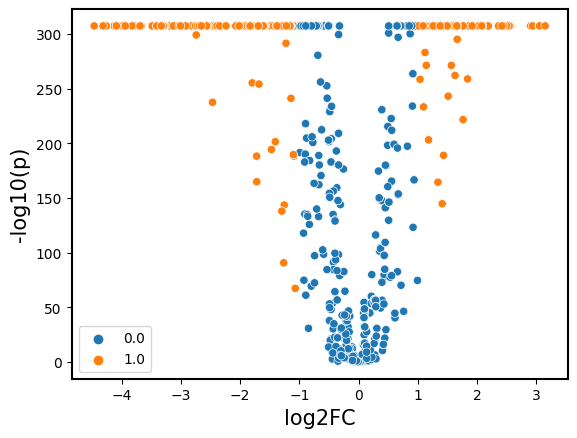

In [7]:
# generate a mask by thresholds
mask = image.GetArray(700,2)
# mask containse labels (0: background, 1: HT (healthy tissue), 2: CT (cancerous tissue))
mask = (mask > 300).astype(np.int16) + (mask > 100).astype(np.int16)

p_fc_sig = volcano.volcano_plot_data(image, mask, xs)

# Plot
plt.figure()
sea.scatterplot(x=p_fc_sig[:,1], y=-np.log10(p_fc_sig[:,0]),hue=p_fc_sig[:,2])
plt.xlabel("log2FC")
plt.ylabel("-log10(p)")


<Figure size 640x480 with 0 Axes>

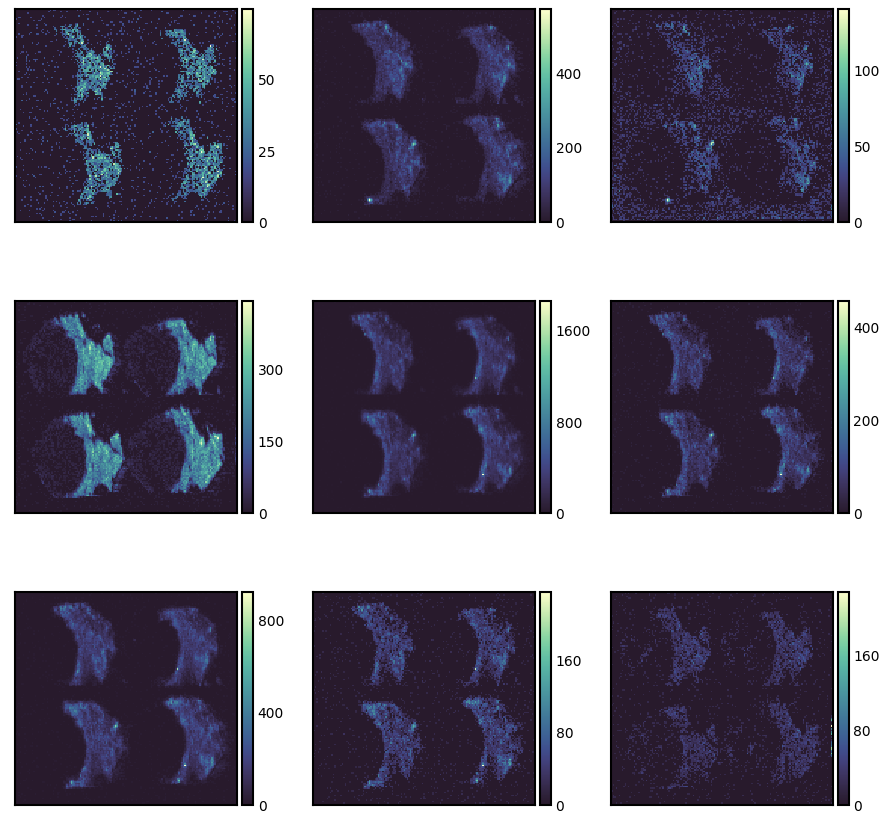

In [13]:
# Example images
images = []
neg_log10p = -np.log10(p_fc_sig[:,0])
log2FC = p_fc_sig[:,1]
for x in xs[np.logical_and(neg_log10p > 300,log2FC > 2)]:
    images.append(image.GetArray(x,100*x*10e-6)[0])

plt.figure()
seai.ImageGrid(images[:9])
